In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import expon, geom
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from utils import despine_ax, get_filenames
from loaders import SpikeRecording
plt.style.use('jns')

In [2]:
# def plot_rebound(ix, ax):
#     start = 905

#     spiketrain = pd.read_csv(tgstn_files[ix], sep='\t')['spike times'].values
#     spiketrain = spiketrain[(spiketrain < 1800)]

#     spikerec = SpikeRecording(spiketrain, 0, 1800)
#     print(spikerec.threshold())

#     spiketrain = spikerec.spiketrain

#     isis = np.diff(spiketrain)
#     xx = np.arange(len(isis))

#     mask_response = (spiketrain[:-1] > 900) & (spiketrain[:-1] < 902)

#     ax.scatter(xx[~mask_response], isis[~mask_response], s=5)
#     ax.scatter(xx[mask_response], isis[mask_response], s=5)
#     ax.set_yscale('log')
#     ax.set_ylabel('ISI (s)')
#     ax.set_xlabel('ISI index')

# fig, axes = plt.subplots(figsize=(5.2,4), nrows=2)

# plot_rebound(9, axes[0])
# axes[0].set_xlabel('')
# plot_rebound(2, axes[1])

# axes[0].set_title('1ng dose', loc='left')
# axes[1].set_title('10g dose', loc='left')

# plt.tight_layout()
# plt.savefig('img/rebound.png')

In [3]:
tgstn_files_10pg = get_filenames('data/tungsten recordings/rebound/10pg', contains='txt')
tgstn_files_1ng = get_filenames('data/tungsten recordings/rebound/1ng', contains='txt')
tgstn_files = tgstn_files_10pg + tgstn_files_1ng

In [4]:
def func(x, a1, b1, a2, b2, c):
    return a1*np.exp(-x/b1)+a2*np.exp(-x/b2)+c

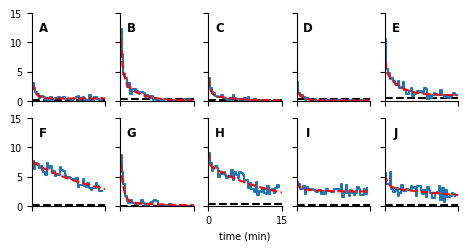

In [5]:
def plot_rebound(axes):
    start = 905
    # 4, 10
    ix = 11

    ixs = [0,1,2,3,5,6,7,8,9,11]

    params = []
    fitted_names = ['a1','b1','a2','b2','c']

    for ix, ax in zip(ixs, axes.flat):
        params.append({})
        spiketrain = pd.read_csv(tgstn_files[ix], sep='\t')['spike times'].values
        spiketrain = spiketrain[(spiketrain < 1800)]
        spont = (spiketrain < 900).sum() / 900
        spiketrain = spiketrain - start

        bin_width = 20
        bins = np.arange(0, 900, bin_width)

        # plt.hist(spiketrain, bins=bins)
        ax.axhline(spont, color='black', linestyle='dashed')

        counts, bins = np.histogram(spiketrain, bins)
        counts = counts / bin_width

        bounds = np.array([(0, np.inf), (1e-3, np.inf), (0, np.inf), (1e-3, np.inf), (0, np.inf)]).T
        x = bins[:-1]
        popt, pcov = curve_fit(func, x, counts, p0=(2, 40, 2, 200, 1), bounds=bounds)

        for key, p in zip(fitted_names, popt):
            params[-1][key] = p

        params[-1]['spont'] = spont

        ax.step(bins[:-1], counts, where='post')

        xx = np.linspace(0,900, 10000)
        ax.plot(xx, func(xx, *popt), linestyle='dashed', color='red', label=r'$a_1\exp(-t/\tau_1)+a_2\exp(-t/\tau_2)+c$')
        ax.set_ylim(0,15)
        ax.set_xlim(0,15*60)

    axes[1,2].set_xlabel('time (min)')

    xticks = [0, 900]
    for ax in axes.flat:
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
        ax.set_yticks([0, 5, 10, 15])
        
        
    for ax in axes[:,1:].flat:
        ax.set_yticklabels([])
        
    return pd.DataFrame(params)
    

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(5.5,2.5), sharey=True)

params = plot_rebound(axes)
axes[0,0].set_yticklabels([0, 5, 10, 15])
axes[1,0].set_yticklabels([0, 5, 10, 15])
axes[1,2].set_xticklabels([0, 15])

letters = ['A','B','C','D','E','F','G','H','I','J']

for ax, l in zip(axes.flat, letters):
    ax.set_title(l, x=0.15, y=0.7, fontweight='bold')

# plt.savefig('img/rebound.png')

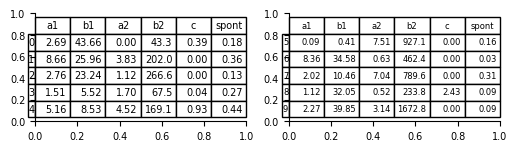

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(6,1.4))

df = params.copy()

for col in ['a1','b1','a2','c','spont']:
    df[col] = df[col].map(lambda x: f'{x:.2f}')

df['b2'] = df['b2'].map(lambda x: f'{x:.1f}')

df1 = df.iloc[:5]
df2 = df.iloc[5:]

pd.plotting.table(axes[0], df1, loc='center')
pd.plotting.table(axes[1], df2, loc='center')

In [11]:
print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &    a1 &     b1 &    a2 &      b2 &     c & spont \\
\midrule
0 &  2.69 &  43.66 &  0.00 &    43.3 &  0.39 &  0.18 \\
1 &  8.66 &  25.96 &  3.83 &   202.0 &  0.00 &  0.36 \\
2 &  2.76 &  23.24 &  1.12 &   266.6 &  0.00 &  0.13 \\
3 &  1.51 &   5.52 &  1.70 &    67.5 &  0.04 &  0.27 \\
4 &  5.16 &   8.53 &  4.52 &   169.1 &  0.93 &  0.44 \\
5 &  0.09 &   0.83 &  7.51 &   927.1 &  0.00 &  0.16 \\
6 &  8.36 &  34.58 &  0.63 &   462.4 &  0.00 &  0.03 \\
7 &  2.02 &  10.45 &  7.04 &   789.6 &  0.00 &  0.31 \\
8 &  1.12 &  32.05 &  0.52 &   233.8 &  2.43 &  0.09 \\
9 &  2.27 &  39.85 &  3.14 &  1672.8 &  0.00 &  0.09 \\
\bottomrule
\end{tabular}



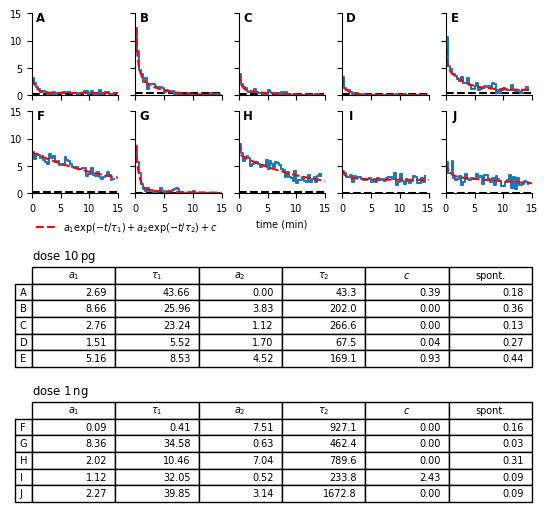

In [24]:
fig = plt.figure(figsize=(5, 4.5))

gs_plots = fig.add_gridspec(2,5, top=1, bottom=0.6, left=0, right=1)

axes = np.empty((2,5), dtype=object)

for row in range(2):
    for col in range(5):
        axes[row, col] = fig.add_subplot(gs_plots[row, col])
        
        
params = plot_rebound(axes)
letters = ['A','B','C','D','E','F','G','H','I','J']

for ax, l in zip(axes.flat, letters):
    ax.set_title(l, x=0.1, y=0.8, fontweight='bold')
    ax.set_xticks([0, 5*60, 10*60, 15*60])
    
for ax in axes[1,:]:
    ax.set_xticklabels([0, 5, 10, 15])

axes[1,0].legend(loc=(0,-0.55), frameon=False)

gs_tables = fig.add_gridspec(2,1, top=0.35, bottom=0., left=0, right=1, hspace=5)

axes = [fig.add_subplot(gs_tables[i]) for i in range(2)]

df = params.copy()

for col in ['a1','b1','a2','c','spont']:
    df[col] = df[col].map(lambda x: f'{x:.2f}')

df['b2'] = df['b2'].map(lambda x: f'{x:.1f}')

df.columns = [r'$a_1$', r'$\tau_1$', r'$a_2$', r'$\tau_2$', r'$c$', 'spont.']
df.index = [f' {l} ' for l in letters]

df1 = df.iloc[:5]
df2 = df.iloc[5:]

pd.plotting.table(axes[0], df1, loc='center')
pd.plotting.table(axes[1], df2, loc='center')

for ax in axes:
    despine_ax(ax)
    
axes[0].set_title(r'dose 10$\,$pg', loc='left', x=0, y=2.7)
axes[1].set_title(r'dose 1$\,$ng', loc='left', x=0, y=2.7)

plt.savefig('img/rebound_with_tables.png')

In [33]:
np.empty((5,2))

array([[0.01 , 0.02 ],
       [0.025, 0.05 ],
       [0.1  , 0.2  ],
       [0.25 , 0.5  ],
       [1.   , 2.   ]])

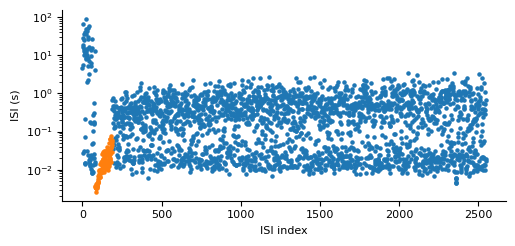

In [38]:
fig, ax = plt.subplots(figsize=(5.2,2.5))



plt.tight_layout()
plt.savefig('img/rebound.png')